In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv
import sys
from tqdm.notebook import tqdm
import math
from IPython.display import FileLink
import gzip
import os


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


"""for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break"""


# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

for dirname, _, filenames in os.walk('/kaggle/input/ecg-retrieval-static-integrated'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
try:
    for line in open('/kaggle/input/ecg-retrieval-static-integrated/running_log'):
        print(line.strip())
except:
    pass

count_label_dict = {82: 51162, 81: 14897, 57: 14733, 83: 11989, 46: 8344, 67: 6867, 90: 6573, 8: 6269, 61: 5412, 49: 5202, 76: 4484, 78: 4030, 80: 3649, 2: 3389, 84: 2996, 0: 2847, 75: 2826, 66: 2724, 58: 2597, 24: 2249, 51: 2104, 33: 1972, 42: 1947, 114: 1932, 86: 1886, 68: 1822, 110: 1718, 69: 1665, 62: 1409, 115: 1380, 91: 1361, 71: 1354, 17: 1324, 44: 1290, 47: 1255, 85: 1161, 60: 1105, 41: 1043, 87: 980, 94: 921, 10: 802, 88: 738, 19: 682, 35: 668, 116: 644, 118: 644, 98: 558, 121: 552, 7: 428, 100: 413, 106: 410, 63: 392, 95: 367, 70: 353, 6: 324, 103: 315, 104: 310, 64: 300, 15: 278, 117: 276, 55: 276, 122: 269, 77: 260, 107: 251, 14: 247, 32: 220, 48: 202, 27: 199, 13: 189, 119: 184, 74: 177, 21: 161, 34: 156, 52: 110, 26: 106, 96: 103, 113: 99, 16: 94, 120: 92, 79: 83, 109: 81, 108: 74, 43: 72, 11: 69, 1: 68, 23: 67, 9: 60, 12: 52, 45: 47, 72: 46, 112: 46, 101: 44, 38: 32, 102: 28, 93: 23, 4: 19, 111: 14, 59: 14, 73: 14, 29: 13, 89: 12, 65: 10, 105: 7, 40: 6, 97: 5, 31: 5, 39: 4, 5: 2, 99: 2, 25: 2, 50: 1, 36: 1, 20: 1}

/kaggle/input/ecg-retrieval-static-integrated/patient-4210.jpg
/kaggle/input/ecg-retrieval-static-integrated/__results__.html
/kaggle/input/ecg-retrieval-static-integrated/__notebook__.ipynb
/kaggle/input/ecg-retrieval-static-integrated/__output__.json
/kaggle/input/ecg-retrieval-static-integrated/custom.css
/kaggle/input/ecg-retrieval-static-integrated/__results___files/__results___22_1.png


In [2]:
"""data schema:
key, base64_data, base64_label, features
"""
import multiprocessing

path = {}

download_and_use_pretrained_model = False

is_load_from_pretrain = False
path['pretrain_model_path'] = '/kaggle/input/ecg-retrieval-static-integrated/step13920'

shuffle = True
is_gzip_file = False
valid_ratio = 0.05  #5948 samples
test_ratio = 0.05   #5948 samples
train_ratio = 1 - valid_ratio - test_ratio   #107064 samples
worker_num = multiprocessing.cpu_count()
#worker_num = 8

topk = 20
feature_index = 0
label_index = 1

epochs = 10
batch_size = 128
learning_rate = 5e-4
#learning_rate = 3e-3
is_warmup_decay = 1
warmup_ratio = 0.1
threshold = 0.5
sigmoid_input = False

use_optimizer = "adam"
use_l2_penalty = False
adam_epsilon = 1e-8

use_float32 = False

use_selected_label = False
rhythm_labels = [8, 80, 81, 82, 83]
top_10_labels = [82, 81, 57, 83, 46, 67, 90, 8, 61, 49]
top_30_labels = [82, 81, 57, 83, 46, 67, 90, 8, 61, 49, 76, 78, 80, 2, 84, 0, 75, 66, 58, 24, 51, 33, 42, 114, 86, 68, 110, 69, 62, 115]
select_label = rhythm_labels

use_sto_features = False
use_reranking = True
load_samples = True
save_samples = False

leads = 12
num_samples = 118960
num_class = 123
feature_size = 242

path['use_resnet'] = 'resnet34'
    
if use_selected_label: 
    num_class = len(select_label)
print("num_class ", num_class)

steps_per_epochs = int(num_samples/batch_size)
num_steps = steps_per_epochs * epochs
save_step = int(num_steps/10)
decay_step = [int(num_steps*0.6), int(num_steps*0.8)]
warmup_step = max(2*steps_per_epochs, int(num_steps/10))
#evaluate_step = int(num_steps/10)
evaluate_step = steps_per_epochs * 30

num_class  123


In [3]:
num_steps

9290

In [4]:
#load train file list, valid file list and test file list
import os

path['input_data'] = ['/kaggle/input/static-integrated-data1',
                      '/kaggle/input/static-integrated-data2',
                      '/kaggle/input/static-integrated-data3',
                      '/kaggle/input/static-integrated-data4']

def get_train_val_test_list(paths):
    files = []
    for dir_add in paths:
        f_adds = os.listdir(dir_add)
        f_adds = sorted(f_adds)
        for i,f_add in enumerate(f_adds.copy()):
            if '.part' not in f_add:
                #print(f_add)
                f_adds.remove(f_add)
            else:
                f_add = dir_add + '/' + f_add
                files.append(f_add)
    num_samples = len(files)
    num_valids = int(valid_ratio * num_samples)
    num_tests = int(test_ratio * num_samples)
    num_trains = num_samples - num_valids - num_tests
    #return train_list, valid_list, test_list
    return files[:num_trains], files[num_trains:num_trains+num_valids], files[num_trains+num_valids:]
    
path['train_list'], path['valid_list'], path['test_list'] = get_train_val_test_list(path['input_data'])

In [5]:
print(len(path['train_list']))
print(len(path['valid_list']))
print(len(path['test_list']))

107064
5948
5948


In [6]:
import torch
import gzip
from torch.utils import data
import base64
import linecache

class MyDataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
        
    def __init__(self, paths, out_feature=True):
        
        self.files = paths
            
        self.out_feature = out_feature
        
    def parse_line(self, line, f_add):
        try:
            index_name, index_data, index_label, index_feature, features = line.strip().split('\t')
        except:
            index_name, index_data, index_label, index_feature = line.strip().split('\t')
            features = None
        
        index_data = base64.b64decode(index_data)
        index_data = np.frombuffer(index_data, dtype=np.float16).reshape(-1,12).transpose()
        
        index_label = base64.b64decode(index_label)
        index_label = np.frombuffer(index_label, dtype=np.float16)
        
        if features != None:
            features = base64.b64decode(features)
            features = np.fromstring(features, dtype=np.float16)
        else:
            features = np.array([0] * feature_size)
    
        features[~np.isfinite(features)] = 0
        
        if use_selected_label:
            index_label = np.asarray([index_label[i] for i in select_label], dtype=np.float16)
                    
        if use_float32:
            index_data = index_data.astype(np.float32)
            index_label = index_label.astype(np.float32)
                
        assert len(index_label) == num_class
        
        sample = {}
        sample['file_name'] = f_add
        sample['index_name'] = index_name
        sample['index_data'] = index_data
        sample['index_label'] = index_label
        sample['index_feature'] = index_feature
        sample['features'] = features
        
        return sample
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.files)

    def __getitem__(self, index):
        'Generates one sample of data'
        
        f_add = self.files[index]
        with open(f_add, 'r') as f:
            line = f.read()
            sample = self.parse_line(line, f_add)
    
        return sample

train_set = MyDataset(path['train_list'],out_feature=True)
valid_set = MyDataset(path['valid_list'],out_feature=True)
test_set = MyDataset(path['test_list'],out_feature=True)
train_generator = data.DataLoader(train_set, batch_size=batch_size, shuffle=shuffle, num_workers=worker_num)
valid_generator = data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=worker_num)
test_generator = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=worker_num)
print("train set size: ", train_set.__len__())
print("valid set size: ", valid_set.__len__())
print("test set size: ", test_set.__len__())

train set size:  107064
valid set size:  5948
test set size:  5948


In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class BasicModule(nn.Module):
    def __init__(self):
        super(BasicModule, self).__init__()

    def init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0.01)

    def load(self, path):
        self.load_state_dict(torch.load(path))
        
def activation(act_type='prelu'):
    if act_type == 'prelu':
        act = nn.PReLU()
    elif act_type == 'relu':
        act = nn.ReLU(inplace=True)
    else:
        raise NotImplementedError
    return act


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv1d(in_planes, out_planes, kernel_size=7, stride=stride,
                     padding=3, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = activation('relu')
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm1d(planes)
        self.downsample = downsample
        self.stride = stride
        self.dropout = nn.Dropout(.2)
        #self.dropout = nn.Dropout(.5)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv1d(inplanes, planes, kernel_size=7, bias=False, padding=3)
        self.bn1 = nn.BatchNorm1d(planes)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=11, stride=stride,
                               padding=5, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)
        self.conv3 = nn.Conv1d(planes, planes * 4, kernel_size=7, bias=False, padding=3)
        self.bn3 = nn.BatchNorm1d(planes * 4)
        self.relu = activation('relu')
        self.downsample = downsample
        self.stride = stride
        self.dropout = nn.Dropout(.2)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(BasicModule):

    def __init__(self, block, layers, num_classes=num_class):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv1d(leads, 64, kernel_size=15, stride=2, padding=7,
                               bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn_sto = nn.BatchNorm1d(feature_size)
        self.relu = activation('relu')
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.use_sto = use_sto_features
        
        self.fc_size = 512
        if self.use_sto:
            self.fc_size += 64
            
        print("block.expansion",block.expansion)
        self.fc1 = nn.Linear(self.fc_size * block.expansion, int(self.fc_size * block.expansion/4))
        self.fc2 = nn.Linear(int(self.fc_size * block.expansion/4), num_classes)
        self.fc_sto = nn.Linear(feature_size, 64)
        self.dropout = nn.Dropout(.2)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc_sto.weight)
        # V1
        #self.avgpool = nn.AdaptiveAvgPool1d(2)
        #self.fc = nn.Linear(2 * 512 * block.expansion, num_classes)
        # v2
        #self.conv2 = nn.Conv1d(2048, 64, kernel_size=1, stride=1, padding=0,
        #                       bias=False)
        #self.bn2 = nn.BatchNorm1d(64)
        #self.avgpool = nn.AdaptiveAvgPool1d(8)
        #self.fc = nn.Linear(64 * 8, num_classes)
        
        self.sigmoid = nn.Sigmoid()
        self.init()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, data, features):
        x01 = self.conv1(data)
        x02 = self.bn1(x01)
        x03 = self.relu(x02)
        x0 = self.maxpool(x03)

        x1 = self.layer1(x0)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        x_final = self.avgpool(x4)
        x_final = x_final.view(x_final.size(0), -1)

        #sex = sex.unsqueeze(1)
        #inp = torch.cat([x, age, sex], 1)
        
        assert not (torch.isnan(features).any() or features.eq(float('inf')).any() or features.eq(float('-inf')).any())
        
        if self.use_sto:
            #features = self.bn_sto(features)
            features = self.fc_sto(features)
            x_final = torch.cat([x_final, features], 1)

        fc1_out = self.fc1(self.dropout(x_final))
        fc2_out = self.fc2(self.dropout(self.relu(fc1_out)))
        
        #x = self.sigmoid(x)

        #return fc2_out, torch.cat([x_final,fc1_out,fc2_out], dim=-1)
        return fc2_out, x_final

In [8]:
import math
from torch.utils import data
import gc
from torch.optim import Adam, AdamW, Adagrad, SGD, RMSprop
from time import time
from random import random
from torch.autograd import Variable
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
n_gpu = torch.cuda.device_count()
print("train on: ", device)
print("n_gpu: ", n_gpu)


def warmup_decap(current_step, num_steps, warmup_step, decay_step, lr_decay_ratio=0.1):
    #current_step < warmup_step
    if current_step < warmup_step:
        return current_step * 1.0 / warmup_step
    #curret_step > decay_step
    for i,step in enumerate(list(reversed(decay_step))):
        if current_step > step:
            return pow(lr_decay_ratio, len(decay_step) - i)
    #warmup_step < curret_step < decay_step
    return 1.0

#计算F1score
def calc_f1(y_true, y_pre, threshold=0.5):
    y_true = y_true.view(-1).cpu().detach().numpy().astype(np.int)
    y_pre = y_pre.view(-1).cpu().detach().numpy() > threshold
    return f1_score(y_true, y_pre)

def load_from_pretrain(model, model_path, optimizer):
    print('load from ', model_path)
    #load pre_trained dict
    model_dict = model.state_dict()
    try:
        checkpoint = torch.load(model_path)
    except:
        checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
    
    try:
        pretrained_dict = checkpoint["net"]
        optimizer.load_state_dict(checkpoint["optimizer"])  # load optimizer
        print('optimizer loaded')
    except: 
        pretrained_dict = checkpoint
        
    # 1. filter out unnecessary keys
    #pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if
                           (k in model_dict) and (model_dict[k].shape == pretrained_dict[k].shape)}
    # 2. overwrite entries in the existing state dict
    model_dict.update(pretrained_dict) 
    # 3. load the new state dict
    model.load_state_dict(model_dict, strict=False)
    print('pretrain_model loaded')
    
    return model, optimizer
    
def evaluate(model, valid_generator):
    print('evaluating...')
    model.eval()
    v_loss = 0.
    f1_all = 0.
    num_batches_per_epoch = 0
    samples = {}
    samples['file_name'] = []
    samples['dynamic_features'] = []
    samples['index_label'] = []
    with torch.no_grad():
        for batch_samples in tqdm(valid_generator):
                
            batch_data = batch_samples["index_data"].type(torch.FloatTensor).to(device)
            batch_label = batch_samples["index_label"].type(torch.FloatTensor).to(device)
            batch_feature = batch_samples["features"].type(torch.FloatTensor).to(device)
            
            logit, batch_feature = model(batch_data, batch_feature)
            
            samples['file_name'].extend(batch_samples['file_name'])
            samples['dynamic_features'].extend(batch_feature.cpu().detach().numpy())
            samples['index_label'].extend(batch_samples["index_label"].cpu().detach().numpy())
            
            loss = loss_fct(logit, batch_label)
            
            f1 = calc_f1(batch_label, torch.sigmoid(logit), threshold)
            f1_all += f1
            num_batches_per_epoch += 1
            
            v_loss += loss.item()
        
            del logit, loss
            #break
    print("valid set's batch loss ", v_loss/num_batches_per_epoch)
    print("valid set's f1 score   ", f1_all/num_batches_per_epoch)
    return v_loss, samples

loss_fct = nn.BCEWithLogitsLoss()

train on:  cpu
n_gpu:  0


In [9]:
import torch.utils.model_zoo as model_zoo
model_urls = {
    'basic_path': 'https://download.pytorch.org/models/',
    'resnet18': 'resnet18-5c106cde.pth',
    'resnet34': 'resnet34-333f7ec4.pth',
    'resnet50': 'resnet50-19c8e357.pth',
    'resnet101': 'resnet101-5d3b4d8f.pth',
    'resnet152': 'resnet152-b121ed1d.pth',
}

def get_optimizer(model, opt="adam"):
    #choose optimizer
    if opt == "adamw":
        print("adamW is used")
        optimizer = AdamW(params=model.parameters(), lr=learning_rate)
        return optimizer
    elif opt == "adam":
        if use_l2_penalty:
            print("adam with w is used")
            optimizer = Adam(params=model.parameters(), lr=learning_rate, weight_decay=adam_epsilon)
            return optimizer
        else:
            print("adam without w is used")
            optimizer = Adam(params=model.parameters(), lr=learning_rate)
            return optimizer

def resnet18(pretrained=False, **kwargs):
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    optimizer = get_optimizer(model, use_optimizer)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model, optimizer


def resnet34(pretrained=False, **kwargs):
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    optimizer = get_optimizer(model, use_optimizer)
    if pretrained:
        !wget https://download.pytorch.org/models/resnet34-333f7ec4.pth
        model, optimizer = load_from_pretrain(model, model_urls['resnet34'], optimizer)
        !rm resnet34-333f7ec4.pth
    return model, optimizer


def resnet50(pretrained=False, **kwargs):
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    optimizer = get_optimizer(model, use_optimizer)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model, optimizer


def resnet101(pretrained=False, **kwargs):
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    optimizer = get_optimizer(model, use_optimizer)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model, optimizer


def resnet152(pretrained=False, **kwargs):
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    optimizer = get_optimizer(model, use_optimizer)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model, optimizer

if path['use_resnet'] == 'resnet18': 
    model, optimizer = resnet18(download_and_use_pretrained_model)
elif path['use_resnet'] == 'resnet34':
    model, optimizer = resnet34(download_and_use_pretrained_model)
elif path['use_resnet'] == 'resnet50':
    model, optimizer = resnet50(download_and_use_pretrained_model)
elif path['use_resnet'] == 'resnet101':
    model, optimizer = resnet101(download_and_use_pretrained_model)
elif path['use_resnet'] == 'resnet152':
    model, optimizer = resnet152(download_and_use_pretrained_model)
model = model.to(device)

block.expansion 1
adam without w is used


In [10]:
"""#if use_float32 == False:
#    model = model.half()

if is_load_from_pretrain == True and path['pretrain_model_path']:
    model, optimizer = load_from_pretrain(model, path['pretrain_model_path'], optimizer)

#count #parameter
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("all: ", total_params, " trainable: ",trainable_params)

np.random.seed(42)
torch.manual_seed(42)
if n_gpu > 0:
    torch.cuda.manual_seed_all(42)
print('BEGIN:')

model.train()
current_step = 0
for epoch in range(epochs):
    start = time()
    train_loss = 0.0
    f1_all_train = 0.
    num_batches_per_epoch = 0
    for batch_samples in tqdm(train_generator):
        
        batch_data = batch_samples["index_data"].to(device).type(torch.cuda.FloatTensor)
        batch_label = batch_samples["index_label"].to(device).type(torch.cuda.FloatTensor)
        batch_feature = batch_samples["features"].to(device).type(torch.cuda.FloatTensor)
        
        if sigmoid_input:
            batch_data = torch.sigmoid(batch_data)
            
        optimizer.zero_grad()   #u don't want to forget this
        
        logits, _ = model(batch_data, batch_feature)
        
        #print(logits)
        
        loss = loss_fct(logits, batch_label)
        #print(loss)
            
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        current_step += 1
        num_batches_per_epoch += 1
        
        #tune learning rate
        if is_warmup_decay:
            lr_this_step = learning_rate * warmup_decap(current_step, num_steps, warmup_step, decay_step)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_this_step
        
        #evaluation
        if current_step % evaluate_step == 0:
            
            print('current step: ', current_step)
            print('current lr: ', lr_this_step)
            
            save_path = 'checkpoint_step'+(str(current_step))
            torch.save({
                "step": current_step,
                "loss": train_loss/num_batches_per_epoch,
                "net": model.state_dict(),
                "optimizer": optimizer.state_dict()
            }, save_path)
            
            dev_loss,_ = evaluate(model, valid_generator)
            model.train()   #very important
            print('model saved, save step: ', current_step)
            
            path['best_model'] = save_path
        
        f1 = calc_f1(batch_label, torch.sigmoid(logits), threshold)
        f1_all_train += f1
        
        del logits, loss, batch_data, batch_label
        
    end = time()
    print('epoch {}, batch loss {:.3f} - took {} sec'.format(epoch+1, train_loss/num_batches_per_epoch, int(end-start)))
    print('train f1_score: ', f1_all_train/num_batches_per_epoch)
    start = end
    gc.collect()"""

'#if use_float32 == False:\n#    model = model.half()\n\nif is_load_from_pretrain == True and path[\'pretrain_model_path\']:\n    model, optimizer = load_from_pretrain(model, path[\'pretrain_model_path\'], optimizer)\n\n#count #parameter\ntotal_params = sum(p.numel() for p in model.parameters())\ntrainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)\nprint("all: ", total_params, " trainable: ",trainable_params)\n\nnp.random.seed(42)\ntorch.manual_seed(42)\nif n_gpu > 0:\n    torch.cuda.manual_seed_all(42)\nprint(\'BEGIN:\')\n\nmodel.train()\ncurrent_step = 0\nfor epoch in range(epochs):\n    start = time()\n    train_loss = 0.0\n    f1_all_train = 0.\n    num_batches_per_epoch = 0\n    for batch_samples in tqdm(train_generator):\n        \n        batch_data = batch_samples["index_data"].to(device).type(torch.cuda.FloatTensor)\n        batch_label = batch_samples["index_label"].to(device).type(torch.cuda.FloatTensor)\n        batch_feature = batch_samples["fe

In [11]:
#get feature for knn retrieval

import pickle
import warnings
warnings.filterwarnings("ignore")

def get_features(path, train_generator, valid_generator, test_generator, optimizer):
    try:
        model, optimizer = load_from_pretrain(model, path['best_model'], optimizer)
    except:
        model, optimizer = resnet34(download_and_use_pretrained_model)
        if(path.get('best_model',0) != 0):
            model, optimizer = load_from_pretrain(model, path['best_model'], optimizer)
    model = model.to(device)
    train_loss,train_samples = evaluate(model, train_generator)
    valid_loss,valid_samples = evaluate(model, valid_generator)
    test_loss,test_samples = evaluate(model, test_generator)
    
    return train_samples,valid_samples,test_samples

path['best_model'] = '../input/50ep1e30775/50ep1e30.775'
#path['best_model'] = '/kaggle/input/ecg-retrieval-static-integrated/checkpoint_step41805'

if load_samples:
    with open('../input/50ep1e30775/train_samples.pickle', 'rb') as handle:
        train_samples = pickle.load(handle)
    print("train samples loaded")
    with open('../input/50ep1e30775/valid_samples.pickle', 'rb') as handle:
        valid_samples = pickle.load(handle)
    print("valid samples loaded")
    with open('../input/50ep1e30775/test_samples.pickle', 'rb') as handle:
        test_samples = pickle.load(handle)
    if use_selected_label:
        for i in range(len(train_samples['index_label'])):
            train_samples['index_label'][i] = \
                np.asarray([train_samples['index_label'][i][k] for k in select_label], dtype=np.float16)
        for i in range(len(valid_samples['index_label'])):
            valid_samples['index_label'][i] = \
                np.asarray([valid_samples['index_label'][i][k] for k in select_label], dtype=np.float16)
        for i in range(len(test_samples['index_label'])):
            train_samples['index_label'][i] = \
                np.asarray([train_samples['index_label'][i][k] for k in select_label], dtype=np.float16)
    print("test samples loaded")
else:
    train_samples,valid_samples,test_samples = \
        get_features(path,train_generator,valid_generator,test_generator, optimizer)

if save_samples:
    with open('train_samples.pickle', 'wb+') as handle:
        pickle.dump(train_samples, handle)
    with open('valid_samples.pickle', 'wb+') as handle:
        pickle.dump(valid_samples, handle)
    with open('test_samples.pickle', 'wb+') as handle:
        pickle.dump(test_samples, handle)

train samples loaded
valid samples loaded
test samples loaded


In [12]:
%load_ext Cython

In [13]:
%%cython
cdef extern from "complex.h":
    double exp(double complex)
cdef extern from "<math.h>":
    double tanh(double complex)
    double sqrt(double complex)
    
def polynomialKernel(double[:] x, double[:] y):
    cdef int n = x.shape[0]
    cdef double res = 0.
    for i in range(n):
        res += (x[i] * y[i])
    res = res/n + 1.
    return exp(-(res**4))

def cosKernel(double[:] x, double[:] y):
    cdef int n = x.shape[0]
    cdef double res = 0.
    cdef double sumx = 0., sumy = 0.
    for i in range(n):
        res += (x[i] * y[i])
        sumx += (x[i]**2)
        sumy += (y[i]**2)
    res /= (sqrt(sumx*sumy))
    return 1-res

def sigmoidKernel(double[:] x, double[:] y):
    cdef int n = x.shape[0]
    cdef double res = 0.
    for i in range(n):
        res += (x[i] * y[i])
    res = res/n + 1.
    return 1 - tanh(res)

def gaussianKernel(double[:] x, double[:] y):
    cdef int n = x.shape[0]
    cdef double res = 0.
    for i in range(n):
        res += (x[i] - y[i])**2
    res *= -1./n
    return 1 - exp(res)

def chi2Kernel(double[:] x, double[:] y):
    cdef int n = x.shape[0]
    cdef double res = 0.
    for i in range(n):
        res += ((x[i] - y[i])**2 / (x[i] + y[i] + 1e-8))
    return 1 - exp(-res)

def l2Dist(double[:] x, double[:] y):
    cdef int n = x.shape[0]
    cdef double res = 0
    cdef double resbis = 0
    for i in range(n):
        res += (x[i] - y[i])**2
    return res

In [14]:
#k nearest training
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import polynomial_kernel

import time
start = time.time()

#nbrs = NearestNeighbors(n_neighbors=topk, algorithm='brute', metric='braycurtis')
nbrs = NearestNeighbors(n_neighbors=topk, algorithm='brute', metric='euclidean')
nbrs.fit(np.stack((train_samples["dynamic_features"])))

build_time = time.time()
print("knn builded, cost %s second" % str(build_time-start))

valid_distances, valid_indices = nbrs.kneighbors(np.stack(valid_samples["dynamic_features"][:10]).astype('double'))
valid_time = time.time()
print("valid got, cost %s second" % str(valid_time-build_time))

test_distances, test_indices = nbrs.kneighbors(np.stack(test_samples["dynamic_features"][:1000]).astype('double'))
test_time = time.time()
print("test got, cost %s second" % str(test_time-valid_time))
print("cost %s time in total" % str(time.time()-start))

knn builded, cost 0.2635483741760254 second
valid got, cost 0.25691986083984375 second
test got, cost 3.9303481578826904 second
cost 4.451209783554077 time in total


In [15]:
#!pip install fastdtw
#!pip install dtw
#!pip install dtaidistance

In [16]:
import sklearn
import scipy
import matplotlib.pyplot as plt
import scipy

filterAllZeroLabel = False
use_0_1_relevant = False
use_F1_relevant = True
use_F1_corr_relevant = True

def parse_line(f_add):
    
    with open(f_add, 'r') as f:
        line = f.read()
        try:
            index_name, index_data, index_label, index_feature, features = line.strip().split('\t')
        except:
            index_name, index_data, index_label, index_feature = line.strip().split('\t')
            features = None
        
        index_data = base64.b64decode(index_data)
        index_data = np.fromstring(index_data, dtype=np.float16).reshape(-1,12).transpose()
        
        index_label = base64.b64decode(index_label)
        index_label = np.fromstring(index_label, dtype=np.float16)
        
        if features != None:
            features = base64.b64decode(features)
            #features = np.frombuffer(features, dtype=np.float16)
            features = np.fromstring(features, dtype=np.float16)
        else:
            features = np.array([0] * feature_size)
            
        index_data = index_data.astype(np.float64)
        index_label = index_label.astype(np.float64)
        
        features = features.astype(np.float64)
        features[~np.isfinite(features)] = 0
        
        if use_selected_label:
            index_label = np.asarray([index_label[i] for i in select_label], dtype=np.float16)
                    
        assert len(index_label) == num_class
        
        sample = {}
        sample['file_name'] = f_add
        sample['index_name'] = index_name
        sample['index_data'] = index_data
        sample['index_label'] = index_label
        sample['index_feature'] = index_feature
        sample['features'] = features
        
        return sample
    
# compute dcg@k for a single sample
def dcg_at_k(r, k):
    # k should be <= r.size()
    r = np.asfarray(r)[:k]
    if r.size:
        #return r[0] + np.sum(r[1:] / np.log2(np.arange(3, r.size + 2)))
        return np.sum((2**r-1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


# compute ndcg@k (dcg@k / idcg@k) for a single sample
def get_ndcg(r, ref, k):
    dcg_max = dcg_at_k(ref, k)
    if not dcg_max:
        return 0.
    dcg = dcg_at_k(r, k)
    return dcg / dcg_max

def get_pred_vec(pre_label, anchor_label):
    pass

"""def normCorrelation(sample1, sample2):
    corr = []
    for a, b in zip(sample1["index_data"], sample2["index_data"]):
        a = (a - np.mean(a)) / (np.std(a) * len(a))
        b = (b - np.mean(b)) / (np.std(b))
        corr.append(np.correlate(a, b, 'valid'))
    return sum(corr) / len(corr)"""

def KLDist(sample1, sample2):
    kl_d = []
    for a, b in zip(sample1["index_data"], sample2["index_data"]):
        a = [item if item != 0 else 0.01 for item in a]
        b = [item if item != 0 else 0.01 for item in b]
        a = a / np.sum(a)
        b = b / np.sum(b)
        assert sum(a) - 1. < 1e-3 and sum(b) - 1. < 1e-3
        #v = scipy.stats.entropy(a,b)
        v = np.sum(np.where(a != 0, a * np.log(a / b), 0))
        v = 0 if np.isfinite(v) == False else v
        kl_d.append(abs(v))
    return sum(kl_d) / len(kl_d)
    
def plotSignal(signal):
    plt.plot(signal)
    plt.show()
    
def normCorrelation(sample1, sample2):
    corr = []
    for a, b in zip(sample1["index_data"], sample2["index_data"]):
        """a = np.array(normalize(a))
        b = np.array(normalize(b))
        a = (a - np.mean(a)) / (np.std(a))
        b = (b - np.mean(b)) / (np.std(b))"""
        v = np.corrcoef(a, b)[0][1]
        """a = (a - np.mean(a)) / (np.std(a) * len(a))
        b = (b - np.mean(b)) / (np.std(b))
        #v = np.correlate(a, b, 'valid')
        v = np.correlate(a, b, 'valid')[0]"""
        """if v > 0. and v < 0.05:
            print(a)
            print(b)
            plotSignal(a)
            plotSignal(b)"""
        v = 0 if np.isfinite(v) == False else v
        corr.append(abs(v))
    return sum(corr) / len(corr)

def normMI(sample1, sample2):
    nmi = []
    for a, b in zip(sample1["index_data"], sample2["index_data"]):
        v = sklearn.metrics.normalized_mutual_info_score(a, b)
        v = 0 if np.isfinite(v) == False else v
        nmi.append(abs(v))
    return sum(nmi) / len(nmi)

def nrmseDist(sample1, sample2):
    rms = []
    for a, b in zip(sample1["index_data"], sample2["index_data"]):
        #a = (a - np.mean(a)) / (np.std(a))
        #b = (b - np.mean(b)) / (np.std(b))
        a = np.array(normalize(a))
        b = np.array(normalize(b))
        #mean_squared_error(normalize(a), normalize(b))
        v = np.sqrt(((a - b) ** 2).mean())
        #assert v <= 1.0 and v >= 0.0
        v = 0 if np.isfinite(v) == False else v
        rms.append(abs(v))
    return sum(rms)/len(rms)

def cosDist(sample1, sample2):
    cos = []
    for a, b in zip(sample1["index_data"], sample2["index_data"]):
        v = 1 - scipy.spatial.distance.cosine(a,b)
        v = 0 if np.isfinite(v) == False else v
        cos.append(abs(v))
    return sum(cos)/len(cos)

def corr_score(train_index, test_index):
    test_add = test_samples["file_name"][test_index]
    train_add = train_samples["file_name"][train_index]
    sample1 = parse_line(train_add)
    sample2 = parse_line(test_add)
    no = normCorrelation(sample1, sample2)
    return no
    
def getIdeal(test_index):
    test_add = test_samples["file_name"][test_index]
    name = test_add[test_add.rindex('/')+1:]
    return np.array(corr_dict[name], dtype=np.float32), \
            np.array(f1_dict[name], dtype=np.float32)

def load_corr_dict(add):
    corr_dict = {}
    with open(add) as f:
        for line in f:
            data = line.strip().split("\t")
            data = [item if item != "." else "0.0" for item in data]
            name = data[0]
            s1, s2, s3, s4, s5 = data[1:]
            #corr_dict[name] = np.array([s1, s1, s2, s2, s3, s4, s5])
            corr_dict[name] = np.array([s1, s1, s2, s2, s3, s3, s4, s4, s5, s5])
    return corr_dict
  
def load_f1_dict(add):
    f1_dict = {}
    with open(add) as f:
        for line in f:
            data = line.strip().split("\t")
            name = data[0]
            f1_dict[name] = np.array(data[1:])
    return f1_dict

count_labels = [0] * 123
labels_scores_r1 = [0.] * num_class
labels_scores_r5 = [0.] * num_class
labels_scores_r10 = [0.] * num_class
def retrieval_eval_ndcg5(indices, test_labels, train_labels, k):
    count = 0
    score_0_1 = []
    score_0_1_dcg = []
    score_f1_macro = []
    score_f1_micro = []
    score_corr = []
    score_corr_dcg = []
    y_trues = []
    y_preds = []
    
    for c,query in enumerate(indices):
        test_label = test_labels[c].astype(np.int)
        
        if(filterAllZeroLabel and test_label.any() == False): #only search label is valid
            continue
            
        if len(query) == 0: continue
        
        #compute corr scores
        ref_vec_corr, ref_vec_f1 = getIdeal(c)
        pred_vec_corr = [corr_score(q,c) for q in query[:k]]
        res = get_ndcg(pred_vec_corr, ref_vec_corr, min(k,len(query)))
        score_corr.append(sum(pred_vec_corr) / len(pred_vec_corr))
        score_corr_dcg.append(res)
        
        #compute equal scores 
        pred_vec_0_1 = [1.0 if (train_labels[q].astype(np.int) == test_label).all() else 0.0 for q in query[:k]]
        res = get_ndcg(pred_vec_0_1, [1.0] * k, min(k,len(query)))
        assert res <= 1.0
        score_0_1.append(sum(pred_vec_0_1) / len(pred_vec_0_1))
        score_0_1_dcg.append(res)
        
        #compute q-micro scores
        y_true = [test_label]*k
        y_pred = [train_labels[q].astype(np.int) for q in query[:k]]
        y_true = y_true[:len(y_pred)]
        y_pred = y_pred[:len(y_true)]
        y_trues.extend(y_true)
        y_preds.extend(y_pred)
        #print(sklearn.metrics.multilabel_confusion_matrix(y_true=y_true, y_pred=y_pred))
        #print(len(y_true), len(y_pred))
        pred_vec_f1_ma = f1_score(y_true=y_true, y_pred=y_pred, average='macro', zero_division=1)
        pred_vec_f1_mi = f1_score(y_true=y_true, y_pred=y_pred, average='micro', zero_division=1)
        score_f1_macro.append(pred_vec_f1_ma)
        score_f1_micro.append(pred_vec_f1_mi)
        
        count += 1
        #if count == 1: break
        
        #count individual label
        label_count = [i for i, x in enumerate(test_label) if x == 1]
        for label in label_count: 
            count_labels[label] += 1
            train_label = [list(train_labels[q].astype(np.int)) for q in query]
            train_label = [list(item) for item in list(zip(*train_label))]
            try:
                pos = train_label[label].index(1)
                if pos < 10: labels_scores_r10[label] += 1
                if pos < 5: labels_scores_r5[label] += 1
                if pos < 1: labels_scores_r1[label] += 1
            except:
                pass
    
    global_f1_score_macro = f1_score(y_true=y_trues, y_pred=y_preds, average='macro', zero_division=1)
    global_f1_score_micro = f1_score(y_true=y_trues, y_pred=y_preds, average='micro', zero_division=1)
    
    print(count,' sample are valid in ',len(indices),' sample')
    print("score_0_1:%s\tscore_0_1_dcg:%s"%(sum(score_0_1)/count, sum(score_0_1_dcg)/count))
    print("score_corr:%s\tscore_corr_dcg:%s"%(sum(score_corr)/count, sum(score_corr_dcg)/count))
    print("global f1_score micro:%s\taverage f1_score micro:%s"%(global_f1_score_micro, sum(score_f1_micro)/count))
    return score_0_1, score_0_1_dcg, score_f1_macro, score_f1_micro, score_corr, score_corr_dcg

In [17]:
corr_add = "/kaggle/input/50ep1e30775/ideal_corr_dict"
corr_dict = load_corr_dict(corr_add)

f1_add = "../input/ecg-analysis/ideal_dict_f1_123label"
f1_dict = load_f1_dict(f1_add)

print("valid set score: ")
#ndcg5_valid = retrieval_eval_ndcg5(valid_indices, valid_samples["index_label"], train_samples["index_label"], k=topk)
print("test set score: ")
score_0_1, score_0_1_dcg, score_f1, score_f1_dcg, score_corr, score_corr_dcg = \
    retrieval_eval_ndcg5(test_indices, test_samples["index_label"], train_samples["index_label"], k=10)
score_0_1, score_0_1_dcg, score_f1, score_f1_dcg, score_corr, score_corr_dcg = \
    retrieval_eval_ndcg5(test_indices, test_samples["index_label"], train_samples["index_label"], k=5)
score_0_1, score_0_1_dcg, score_f1, score_f1_dcg, score_corr, score_corr_dcg = \
    retrieval_eval_ndcg5(test_indices, test_samples["index_label"], train_samples["index_label"], k=topk)

valid set score: 
test set score: 
1000  sample are valid in  1000  sample
score_0_1:0.6177000000000002	score_0_1_dcg:0.6250027552225704
score_corr:0.08908660762842627	score_corr_dcg:0.26244625731067994
global f1_score micro:0.7160640895824648	average f1_score micro:0.7735155644677159
1000  sample are valid in  1000  sample
score_0_1:0.631	score_0_1_dcg:0.6360932512481241
score_corr:0.10360027019145712	score_corr_dcg:0.28669642937582324
global f1_score micro:0.7302682448105632	average f1_score micro:0.7854180484832587
1000  sample are valid in  1000  sample
score_0_1:0.6039000000000002	score_0_1_dcg:0.6126544734936122
score_corr:0.07894729191752707	score_corr_dcg:0.351137112782389
global f1_score micro:0.7018640008330731	average f1_score micro:0.7586180402752329


In [18]:
#RERANKING
#from dtaidistance import dtw
from scipy.spatial import distance
import math
import numpy as np

def standardized(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    return v / norm

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum() # only difference

def normalize(x):
    x = np.asarray(x)
    ma = np.max(x)
    mi = np.min(x)
    if ma == mi: 
        return x
    #return [(item-mi)/(ma-mi) for item in x]
    return (x - mi) / (ma - mi)

def computeJaccardDist(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return 1 - float(intersection) / union

"""def reciprocalDist(candidates, nbrs):
    t = [train_samples["dynamic_features"][i] for i in candidates]
    distances, indices = nbrs.kneighbors(np.stack(t))
    dist = [computeJaccardDist(candidates, indice) for indice in indices]
    return dist"""

def neighborsFix(neighbors_dist, neighbors_indices):
    neighbors_dist_n = []
    neighbors_indices_n = []
    for i in range(len(neighbors_dist)):
        if  neighbors_dist[i][0] == 0.:
            neighbors_dist_n.append(neighbors_dist[i][1:])
            neighbors_indices_n.append(neighbors_indices[i][1:])
        else:
            neighbors_dist_n.append(neighbors_dist[i][:-1])
            neighbors_indices_n.append(neighbors_indices[i][0:-1])
    return neighbors_dist_n, neighbors_indices_n

def get_rec_neighbors(q_fea, k, nbrs):
    neighbors_dist, neighbors_indices = nbrs.kneighbors(q_fea.reshape(1,-1),k)
    #neighbors_dist, neighbors_indices = neighborsFix(neighbors_dist, neighbors_indices)
    neighbors_dist = neighbors_dist[0]
    neighbors_indices = neighbors_indices[0]
    assert len(neighbors_dist) == k
    neighbors_fea = [train_samples["dynamic_features"][i] for i in neighbors_indices]
    candidates_neighbors_dist, candidates_neighbors_indices = nbrs.kneighbors(np.stack(neighbors_fea), k+1)
    candidates_neighbors_dist = [item[1:] for item in candidates_neighbors_dist]
    candidates_neighbors_indices = [item[1:] for item in candidates_neighbors_indices]
    assert len(candidates_neighbors_dist[0]) == k
    #print("candidates_neighbors_dist: ", candidates_neighbors_dist)
    rec_candidates = [neighbors_indices[i] for i in range(len(neighbors_indices)) if neighbors_dist[i] < candidates_neighbors_dist[i][-1]]
    rec_dist = [neighbors_dist[i] for i in range(len(neighbors_dist)) if neighbors_dist[i] < candidates_neighbors_dist[i][-1]]
    
    #expand invalid set
    """if len(rec_candidates) == 0:
        rec_candidates.append(neighbors_indices[0])
        rec_dist.append(neighbors_dist[0])"""
        
    return neighbors_dist, neighbors_indices, rec_dist, rec_candidates

def reciprocalDist(test_index, q_fea, candidates, nbrs):
    ori_dist, ori_neighbors, q_rec_dist, q_rec_neighbors = get_rec_neighbors(q_fea, topk, nbrs)
    count_new_neighbors = 0
    p_rec_dist_dict = {}
    p_rec_neighbors_dict = {}
    
    p_corrs = []
    for train_index in q_rec_neighbors:
        p_corrs.append(corr_score(train_index, test_index))
    p_corrs_avg = sum(p_corrs)/len(p_corrs) if p_corrs else 0.15
    #print(p_corrs, p_corrs_avg)
           
    for p in q_rec_neighbors.copy():
        p_fea = train_samples["dynamic_features"][p]
        ori_p_dist, ori_p_neighbors, p_rec_dist, p_rec_neighbors = get_rec_neighbors(p_fea, topk, nbrs)
        
        p_rec_dist_dict[str(p)] = p_rec_dist
        p_rec_neighbors_dict[str(p)] = p_rec_neighbors
        
        #expand candidate set
        #if len(list(set(p_rec_neighbors).intersection(q_rec_neighbors))) >= 3./4.*len(p_rec_neighbors):
        if computeJaccardDist(p_rec_neighbors, q_rec_neighbors) <= 1./3.:
           for pp in range(len(p_rec_neighbors)):
                n_p = p_rec_neighbors[pp]
                if n_p not in q_rec_neighbors:
                    
                    """#corr examine
                    if corr_score(n_p, test_index) < p_corrs_avg: continue
                    print("corr_score(n_p, test_index) ", corr_score(n_p, test_index))
                        
                    #update new candidate
                    q_rec_dist.append(p_rec_dist[pp])
                    q_rec_neighbors.append(n_p)
                    #update p_rec_dict
                    pp_fea = train_samples["dynamic_features"][n_p]
                    ori_pp_dist, ori_pp_neighbors, pp_rec_dist, pp_rec_neighbors = \
                            get_rec_neighbors(pp_fea, topk, nbrs)
                    p_rec_dist_dict[str(n_p)] = pp_rec_dist
                    p_rec_neighbors_dict[str(n_p)] = pp_rec_neighbors
                    count_new_neighbors += 1"""
                 
    dist = []
    v_q = np.asarray([0.] * num_samples)
    for d,p in zip(q_rec_dist, q_rec_neighbors):
        v_q[p] = math.exp(-d)
    for p in p_rec_dist_dict:
        p_rec_dist = p_rec_dist_dict[p]
        p_rec_neighbors = p_rec_neighbors_dict[p]
        v_p = np.asarray([0.] * num_samples)
        #print(p_rec_dist, p_rec_neighbors)
        for d,pp in zip(p_rec_dist, p_rec_neighbors):
            #self
            if d - 0.0 < 1e-6: continue
            v_p[pp] = math.exp(-d)
        """print(v_q[np.nonzero(v_q)])
        print(v_p[np.nonzero(v_p)])"""
        intersection = np.sum(np.minimum(v_q, v_p))
        union = np.sum(np.maximum(v_q, v_p))
        #print(intersection, union)
        dist.append(intersection/union)
        #dist.append(-np.linalg.norm(v_q-v_p)/len(p_rec_dist))
        """v = scipy.spatial.distance.cosine(v_q, v_p)
        v = 0 if np.isfinite(v) == False else v
        dist.append(1-v)"""
        
    #
    #print("dist: ",dist)
    """for p in ori_neighbors:
        if len(q_rec_neighbors) == topk: break
        if p not in q_rec_neighbors:
            q_rec_neighbors.append(p)"""
    #print("count_new_neighbors: ",count_new_neighbors)
    return q_rec_neighbors, dist

def dtwDist(sample1, sample2):
    #dist = [dtw.distance_fast(s1, s2) for s1,s2 in zip(sample1["index_data"], sample2["index_data"])]
    #dist = normalize(dist)
    dist = dtw.distance_fast(sample1["index_data"][0], sample2["index_data"][0])
    return dist

def stoDist(sample1, sample2):
    #dist = np.linalg.norm(sample1["features"] - sample2["features"])
    v = scipy.spatial.distance.cosine(sample1["features"], sample2["features"])
    v = 0 if np.isfinite(v) == False else v
    return v


def rerankingDist(test_index, dynamic_fea, sample_add, samples, candidates, nbrs,
                     rec_dist_all, dtw_dist_all, sto_dist_all, corr_dist_all, cos_dist_all):
    dtw_dist = []
    sto_dist = []
    corr_dist = []
    nmi_dist = []
    nrmse_dist = []
    cos_dist = []
    
    smooth = [0.5, 0.475, 0.45, 0.425, 0.40, 0.375, 0.35, 0.325, 0.30, \
                  0.275, 0.25, 0.225, 0.20, 0.175, 0.15, 0.125, 0.10, 0.075, 0.05, 0.025]
    smooth = [item/2 for item in smooth]
    
    sample2 = parse_line(sample_add)
    
    new_neighbors, rec_dist = reciprocalDist(test_index, dynamic_fea, candidates, nbrs)
    #rec_dist = [0]*topk
    #rec_dist = normalize(rec_dist)
    #rec_dist = softmax(rec_dist)
    
    for train_index in candidates:
        train_add = samples["file_name"][train_index]
        sample1 = parse_line(train_add)
        #dtw_dist.append(dtwDist(sample1, sample2))
        dtw_dist.append(1)
        #sto_dist.append(stoDist(sample1, sample2))
        sto_dist.append(1)
        #corr_dist.append(normCorrelation(sample1, sample2))
        corr_dist.append(0)
        #nmi_dist.append(normMI(sample1, sample2))
        #nrmse_dist.append(nrmseDist(sample1, sample2))
        #cos_dist.append(cosDist(sample1, sample2))
        cos_dist.append(0)
    
    #corr_dist = sorted(corr_dist, reverse=True)
    
    dtw_dist = [1-item for item in normalize(dtw_dist)]
    #dtw_dist = [1-item for item in softmax(dtw_dist)]
    sto_dist = [1-item for item in normalize(sto_dist)]
    #sto_dist = [1-item for item in softmax(sto_dist)]
    #rec_dist = [(rec_dist[i] + smooth[i]) for i in range(topk)]
    #sto_dist = [(sto_dist[i] + smooth[i]) for i in range(topk)]
    """print('dtw_dist ',[round(item, 2) for item in dtw_dist])
    print('rec_dist ',[round(item, 2) for item in rec_dist])
    print('sto_dist ',[round(item, 2) for item in sto_dist])
    print('corr_dist ',[round(item, 2) for item in corr_dist])
    print('nrmse_dist ',[round(item, 2) for item in nrmse_dist])"""
    #dist = [(rec_dist[i]+dtw_dist[i]+sto_dist[i])/3. for i in range(len(candidates))]
    dist = rec_dist
    
    #rec_dist_all, dtw_dist_all, sto_dist_all, corr_dist_all, cos_dist_all = [],[],[],[],[]
    rec_dist_all = [rec_dist_all[i] + rec_dist[i] for i in range(min(len(rec_dist),len(rec_dist_all)))]
    dtw_dist_all = [dtw_dist_all[i] + dtw_dist[i] for i in range(min(len(dtw_dist),len(dtw_dist_all)))]
    sto_dist_all = [sto_dist_all[i] + sto_dist[i] for i in range(min(len(sto_dist),len(sto_dist_all)))]
    corr_dist_all = [corr_dist_all[i] + corr_dist[i] for i in range(min(len(corr_dist),len(corr_dist_all)))]
    #nrmse_dist_all = [nrmse_dist_all[i] + nrmse_dist[i] for i in range(topk)]
    cos_dist_all = [cos_dist_all[i] + cos_dist[i] for i in range(min(len(cos_dist),len(cos_dist_all)))]
    
    return new_neighbors, dist, rec_dist_all, dtw_dist_all, sto_dist_all, corr_dist_all, cos_dist_all

def reranking(indices, samples1, samples2, nbrs):
    rec_dist_all = [0]*topk
    dtw_dist_all = [0]*topk
    sto_dist_all = [0]*topk
    corr_dist_all = [0]*topk
    cos_dist_all = [0]*topk
    
    test_rec_indices = []
    
    count = 0
    for test_index, indice in tqdm(enumerate(indices.copy())):
        sample_add = samples2["file_name"][test_index]
        new_neighbors, dist, rec_dist_all, dtw_dist_all, sto_dist_all, corr_dist_all, cos_dist_all = \
            rerankingDist(test_index, samples2["dynamic_features"][test_index], sample_add, samples1, indice, 
                          nbrs, rec_dist_all, dtw_dist_all, sto_dist_all, corr_dist_all, cos_dist_all)
        #print(dist)
        reorder = np.argsort(dist)[::-1]
        #print(reorder, new_neighbors)
        #test_rec_indices.append([new_neighbors[i] for i in reorder])
        test_rec_indices.append(new_neighbors)
        count += 1
        if count == 1000: break
    
    try:
        print("rec ", [round(item / count, 2) for item in rec_dist_all])
        print("dtw ", [round(item / count, 2) for item in dtw_dist_all])
        print("sto ", [round(item / count, 2) for item in sto_dist_all])
        print("corr ",[round(item / count, 4) for item in corr_dist_all])
        print("cos ",[round(item / count, 4) for item in cos_dist_all])
    except:
        pass
    return test_rec_indices

use_reranking = True
#valid_reranked_indices = reranking(valid_indices, train_samples, valid_samples, nbrs)
if use_reranking:
    test_rec_indices = reranking(test_indices, train_samples, test_samples, nbrs)


rec  []
dtw  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
sto  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
corr  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
cos  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [19]:
corr_add = "/kaggle/input/50ep1e30775/ideal_corr_dict"
corr_dict = load_corr_dict(corr_add)

f1_add = "../input/ecg-analysis/ideal_dict_f1_123label"
f1_dict = load_f1_dict(f1_add)

print("valid set score: ")
#ndcg5_valid = retrieval_eval_ndcg5(valid_indices, valid_samples["index_label"], train_samples["index_label"], k=topk)
print("test set score: ")
score_0_1, score_0_1_dcg, score_f1, score_f1_dcg, score_corr, score_corr_dcg = \
    retrieval_eval_ndcg5(test_rec_indices, test_samples["index_label"], train_samples["index_label"], k=10)
score_0_1, score_0_1_dcg, score_f1, score_f1_dcg, score_corr, score_corr_dcg = \
    retrieval_eval_ndcg5(test_rec_indices, test_samples["index_label"], train_samples["index_label"], k=5)
score_0_1, score_0_1_dcg, score_f1, score_f1_dcg, score_corr, score_corr_dcg = \
    retrieval_eval_ndcg5(test_rec_indices, test_samples["index_label"], train_samples["index_label"], k=topk)

valid set score: 
test set score: 
960  sample are valid in  1000  sample
score_0_1:0.6233726025132272	score_0_1_dcg:0.6299061160652595
score_corr:0.10883517948143341	score_corr_dcg:0.31392227797798394
global f1_score micro:0.7534809830856929	average f1_score micro:0.7794956861118042
960  sample are valid in  1000  sample
score_0_1:0.6310243055555554	score_0_1_dcg:0.6358650452121282
score_corr:0.11603355862217299	score_corr_dcg:0.3220883634188709
global f1_score micro:0.7459261965655827	average f1_score micro:0.7849198515137744
960  sample are valid in  1000  sample
score_0_1:0.6192343326455892	score_0_1_dcg:0.6266979904967673
score_corr:0.10667162377419243	score_corr_dcg:0.3346975473382621
global f1_score micro:0.771032380385888	average f1_score micro:0.7767417158482625


In [20]:
stop

NameError: name 'stop' is not defined

In [21]:
print(test_rec_indices[:10])

[[22591], [71371, 39108, 45519, 92713, 58400, 39250, 92949, 18651, 22826, 14592, 77276, 95712, 10306], [54987, 52706, 99168], [440, 27616, 43004, 57099, 41437, 36273, 38231, 71362, 32134, 18892, 76857, 9455, 53111, 876, 65420, 44835], [32346, 27276, 11968, 50746, 56806, 29487, 50672], [101491, 50958, 100001, 8730, 46097, 66615, 69835, 103860, 50340, 105178, 59203, 77815, 33943, 99991, 74453, 43994, 50999, 61745, 86715], [87985, 101742, 65409, 38402, 66972, 48164, 94114, 61744, 20095, 88732, 1381, 26658, 47125, 80078, 13692, 39898, 63030, 6596, 18561], [], [40704], [45145, 100031, 94236, 92680, 30078, 28538, 8622]]


In [22]:
eps = 1e-8
labels_scores_r1_ = [labels_scores_r1[i]*1./(count_labels[i] + eps) for i in range(len(labels_scores_r1))]
labels_scores_r5_ = [labels_scores_r5[i]*1./(count_labels[i] + eps) for i in range(len(labels_scores_r5))]
labels_scores_r10_ = [labels_scores_r10[i]*1./(count_labels[i] + eps) for i in range(len(labels_scores_r10))]
print("count_labels:",["%d：%s"%(count,item) for count,item in enumerate(count_labels)])
print("labels_scores_r1_:",["%d：%s"%(count,round(item * 100, 2)) for count,item in enumerate(labels_scores_r1_)])
print("labels_scores_r5_:",["%d：%s"%(count,round(item * 100, 2)) for count,item in enumerate(labels_scores_r5_)])
print("labels_scores_r10_:",["%d：%s"%(count,round(item * 100, 2)) for count,item in enumerate(labels_scores_r10_)])

count_labels: ['0：150', '1：12', '2：135', '3：0', '4：6', '5：0', '6：6', '7：24', '8：318', '9：0', '10：36', '11：6', '12：0', '13：6', '14：18', '15：18', '16：0', '17：66', '18：0', '19：36', '20：0', '21：6', '22：0', '23：12', '24：93', '25：0', '26：0', '27：0', '28：0', '29：0', '30：0', '31：0', '32：36', '33：117', '34：6', '35：15', '36：0', '37：0', '38：0', '39：0', '40：0', '41：66', '42：114', '43：6', '44：84', '45：0', '46：399', '47：54', '48：0', '49：249', '50：0', '51：186', '52：6', '53：0', '54：0', '55：6', '56：0', '57：693', '58：120', '59：0', '60：21', '61：321', '62：96', '63：24', '64：48', '65：0', '66：120', '67：351', '68：72', '69：96', '70：18', '71：54', '72：0', '73：0', '74：15', '75：102', '76：258', '77：12', '78：192', '79：0', '80：105', '81：750', '82：2541', '83：534', '84：135', '85：63', '86：102', '87：63', '88：30', '89：0', '90：258', '91：72', '92：0', '93：0', '94：30', '95：12', '96：6', '97：0', '98：24', '99：0', '100：9', '101：6', '102：0', '103：24', '104：6', '105：0', '106：24', '107：12', '108：0', '109：0', '110：66', '111：0', '112：

In [23]:
candidates = []
for person, (a,b,c,d,e,f) in enumerate(zip(score_0_1, \
                    score_0_1_dcg, score_f1, score_f1_dcg, score_corr, score_corr_dcg)):
    #if (a+b+c+d+e+f)/6 > 0.9 and (a+b+c+d+e+f)/6 < 1.0:
    if e < 0.4 and e > 0.3:
        add1 = test_samples["file_name"][person]
        sample1 = parse_line(add1)
        fea1 = sample1['features'][:2]
        add2 = train_samples["file_name"][test_indices[person][0]]
        sample2 = parse_line(add2)
        fea2 = sample2['features'][:2]
        label = [i for i in range(num_class) if test_samples["index_label"][person][i] == 1.]
        if a == 1.0 and (fea1 != fea2).any():
            print(person,a,b,c,d,e,f)
            print(test_indices[person])
            print(label)
            candidates.append(person)
#label = 632

75 1.0 1.0 1.0 1.0 0.31173699955977585 1.0160019210263966
[ 11027  70743  83598  62360  66636   3814  32686  18636  55388  20191
 104942  45771  61480   8652  86650  14872  71406  27790  24987  53948]
[41, 90]
82 1.0 1.0 1.0 1.0 0.3449104623252649 0.7314517857676247
[ 62272  42719   5272  22140  88280  65967 100290  58900  54819  30266
  54328  61878  54646  24707  30750  70532 105229  13970  33962  55691]
[8]
453 1.0 1.0 1.0 1.0 0.37885248025989265 1.5412547138113626
[ 73312  52333   2496  71291  40962  15403   7350  47279  21706  65837
  74935   2440  53359  71404  48356  66353  91902  94740 105412  21016]
[82]
607 1.0 1.0 1.0 1.0 0.354038682531249 1.1883485360082793
[12047 25346 82336 61639 74297 46865 99028 20688 98568 32369 97616  7730
 43555 66843  3515 78480  2010 46694 16360 38003]
[8]
696 1.0 1.0 1.0 1.0 0.3297404355581152 0.5114642289514274
[ 74019  51164   6485  12624  85480 103480  90187  86243  26965  48835
  85314  66611  89516  79459  81088  29121  67223  66914   8397  4

IndexError: index 4210 is out of bounds for axis 0 with size 1000

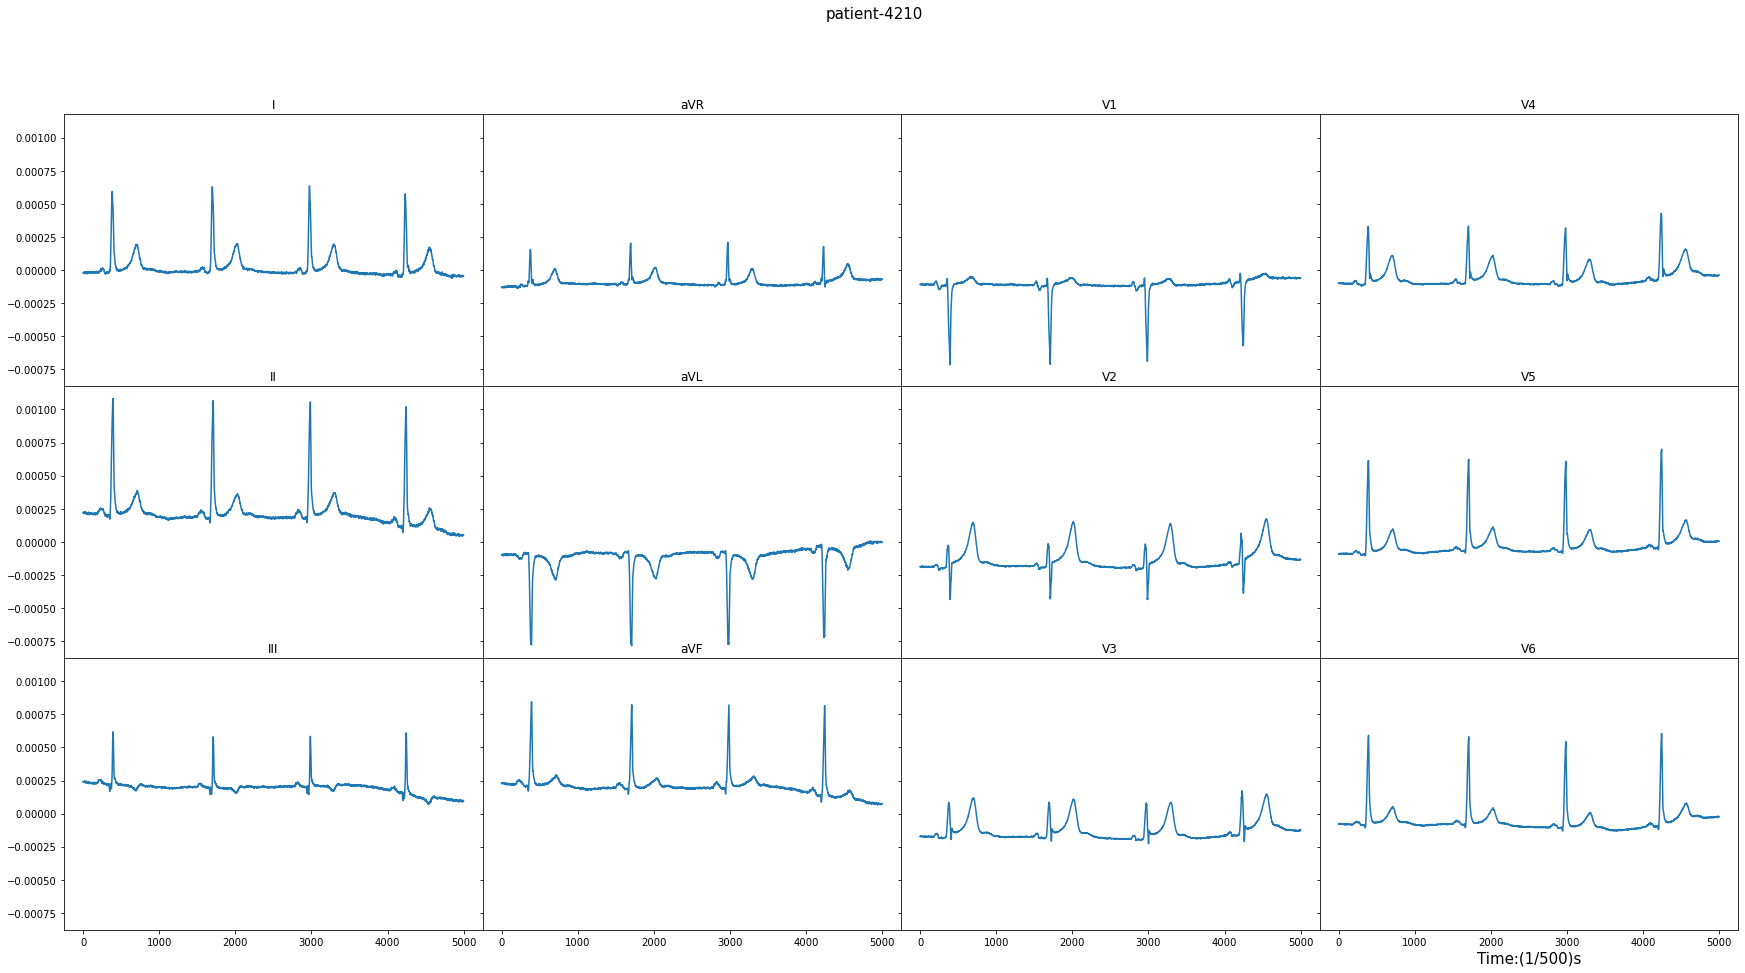

In [24]:
#visualization
# -*- coding:utf-8 -*-
#绘制波形图
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["savefig.format"] = 'png'

# Create new figure and two subplots, sharing both axes
def draw_sample(sample, num_point=1000, title=None):
    
    fig,((I,VR,V1,V4),(II,VL,V2,V5),(III,VF,V3,V6)) = plt.subplots(nrows=3, ncols=4, sharey=True, sharex=True, figsize=(30,15), frameon=False)
    #fig.xlim = (0,num_point)
    #fig.ylim = (-300,300)
    I_WAVE, II_WAVE, III_WAVE, VL_WAVE, VR_WAVE, VF_WAVE, \
        V1_WAVE, V2_WAVE, V3_WAVE, V4_WAVE, V5_WAVE, V6_WAVE= sample
    """III_WAVE = II_WAVE-I_WAVE
    VR_WAVE = -(I_WAVE+II_WAVE)/2
    VL_WAVE = I_WAVE-II_WAVE/2
    VF_WAVE = II_WAVE-I_WAVE/2"""

    st = 0
    ed = num_point
    I.plot(I_WAVE[st:ed])
    I.title.set_text('I')
    II.plot(II_WAVE[st:ed])
    II.title.set_text('II')
    III.plot(III_WAVE[st:ed])
    III.title.set_text('III')

    VR.plot(VR_WAVE[st:ed])
    VR.title.set_text('aVR')
    VL.plot(VL_WAVE[st:ed])
    VL.title.set_text('aVL')
    VF.plot(VF_WAVE[st:ed])
    VF.title.set_text('aVF')

    V1.plot(V1_WAVE[st:ed])
    V1.title.set_text('V1')
    V2.plot(V2_WAVE[st:ed])
    V2.title.set_text('V2')
    V3.plot(V3_WAVE[st:ed])
    V3.title.set_text('V3')
    V4.plot(V4_WAVE[st:ed])
    V4.title.set_text('V4')
    V5.plot(V5_WAVE[st:ed])
    V5.title.set_text('V5')
    V6.plot(V6_WAVE[st:ed])
    V6.title.set_text('V6')

    fig.subplots_adjust(wspace=0, hspace=0)
    plt.xlabel('Time:(1/500)s', fontsize=15)
    #plt.ylabel('Amplitude', fontsize=15)
    if title is not None:
        fig.suptitle(title, fontsize=15)
        fig.savefig(title+'.jpg')
    #fig.show()
    
person = 4210
num_point=5000
#draw_sample(valid_data[person])
test_add = test_samples["file_name"][person]
sample = parse_line(test_add)
draw_sample(sample["index_data"], num_point, u'patient-'+str(person))
for count, i in enumerate(test_indices[person]):
    if count == 5: break
    train_add = train_samples["file_name"][i]
    train_sample = parse_line(train_add)
    draw_sample(train_sample["index_data"], num_point, str(person)+'-relevant patient '+str(count+1))

In [25]:
#!pip install ecg-plot
import ecg_plot
person = 4210
times = 1500
columns = 2
row_height = 4
test_add = test_samples["file_name"][person]
sample = parse_line(test_add)
ecg_plot.plot(sample["index_data"]*times, sample_rate = 500, title = u'Anchor', columns=columns, row_height=row_height, show_separate_line=False)
ecg_plot.save_as_png('Anchor')
#ecg_plot.show()
print('label: ', [i for i in range(num_class) if sample["index_label"][i] == 1.])
print("feature: ", sample['features'][:2])
for count, i in enumerate(test_indices[person]):
    if count == 5: break
    train_add = train_samples["file_name"][i]
    train_sample = parse_line(train_add)
    ecg_plot.plot(train_sample["index_data"]*times, sample_rate = 500, title = 'Relevant patient '+str(count+1), columns=columns, row_height=row_height, show_separate_line=False)
    ecg_plot.save_as_png('Relevant patient '+str(count+1))
    ecg_plot.show()
    print('label: ', [l for l in range(num_class) if train_sample['index_label'][l] == 1.])
    print("feature: ", train_sample['features'][:2])

ModuleNotFoundError: No module named 'ecg_plot'

In [26]:
!ls

__notebook__.ipynb  patient-4210.jpg
